In [1]:
import tensorflow as tf

# Create TensorFlow object called tensor
hello_constant = tf.constant('Hello World!')

with tf.Session() as sess:
    # Run the tf.constant operation in the session
    output = sess.run(hello_constant)
    print(output)

b'Hello World!'


# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [2]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
#importing some useful packages
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#import cv2
%matplotlib inline

In [3]:
# Load pickled data
import pickle


# TODO: fill this in based on where you saved the training and testing data
training_file ='train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print(len(np.unique(y_train)))


43


In [4]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape =X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

n_input = np.prod(X_train[0].shape)
learning_rate = 0.001
batch_size = 128
training_epochs = 30

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


def one_hot_encode(y, num_examples, num_classes):
    ret_y = np.zeros((num_examples, num_classes))
    for r in range(num_examples):
        ret_y[r][y[r]] = 1
    return ret_y

encoded_train_labels=one_hot_encode(y_train,len(y_train),n_classes)
encoded_test_labels=one_hot_encode(y_test,len(y_test),n_classes)



Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


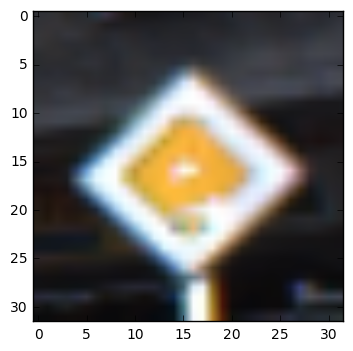

In [5]:
plt.imshow(X_train[20000])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
indices = np.arange(4)
print(indices)

print(indices[2:])
print(indices[-3:-1])
randomized_indices=np.arange(4)
np.random.shuffle(randomized_indices)
print(randomized_indices)

mat=np.array([[12,15,65],[54,2,6],[667,32,16],[6,757,34]])
print(mat)
print("fdjalskfjklasdfj")

print(mat[randomized_indices])

[0 1 2 3]
[2 3]
[1 2]
[0 2 3 1]
[[ 12  15  65]
 [ 54   2   6]
 [667  32  16]
 [  6 757  34]]
fdjalskfjklasdfj
[[ 12  15  65]
 [667  32  16]
 [  6 757  34]
 [ 54   2   6]]


In [7]:
class data:
    
    def __init__(self,X_train,y_train,X_test,y_test):
        self.training_data=X_train
        self.labels_training_data=y_train
        self.testing_data=X_train
        self.labels_testing_data=y_train        
        self.train=len(X_train)
        self.test=len(X_test)
             
        
        train_indices = np.arange(self.train)
        randomized_train_indices=np.arange(self.train)
        np.random.shuffle(randomized_train_indices)
        
        self.randomized_training_data=self.training_data[randomized_train_indices]
        self.randomized_labels_training_data=self.labels_training_data[randomized_train_indices]
        
        test_indices = np.arange(self.test)
        randomized_test_indices=np.arange(self.test)
        np.random.shuffle(randomized_test_indices)
        
        self.randomized_testing_data=[randomized_test_indices]
        self.randomized_labels_testing_data=[randomized_test_indices]
        self.bookmark=0
        
        
    def next_batch(self,batch_size):
        if self.bookmark+batch_size<=self.train:
            batch_x=self.randomized_training_data[self.bookmark:self.bookmark+batch_size]
            batch_y=self.randomized_labels_training_data[self.bookmark:self.bookmark+batch_size]
            self.bookmark=self.bookmark+batch_size
        elif self.bookmark+batch_size>self.train & self.bookmark<=self.train:
            batch_x=self.randomized_training_data[self.bookmark:]
            batch_y=self.randomized_labels_training_data[self.bookmark:]
            
        return batch_x,np.array(batch_y)
    
Data=data(X_train,encoded_train_labels,X_test,encoded_test_labels)


In [8]:
layer_width = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3': 128,
    'fully_connected': 512
}


weights = {
    #32x32x3 5x5x3x32 16x16x32
    'layer_1': tf.Variable(tf.truncated_normal(
        [5, 5, 3, layer_width['layer_1']])),
    #16x16x32 5x5x32x64  8x8x64
    'layer_2': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_1'], layer_width['layer_2']])),
    #8x8x64 5x5x64x128 4x4x128
    'layer_3': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_2'], layer_width['layer_3']])),
    #4x4x128 4x4x128x512 512
    'fully_connected': tf.Variable(tf.truncated_normal(
        [4*4*128, layer_width['fully_connected']])),
    #512 512x43 43
    'out': tf.Variable(tf.truncated_normal(
        [layer_width['fully_connected'], n_classes]))
}
biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_width['layer_2'])),
    'layer_3': tf.Variable(tf.zeros(layer_width['layer_3'])),
    'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
    'out': tf.Variable(tf.zeros(n_classes))
}



In [9]:
def conv2d(x,W,b,strides=1):
    x=tf.nn.conv2d(x,W,strides=[1,strides,strides,1],padding='SAME')
    x=tf.nn.bias_add(x,b)
    return tf.nn.relu(x)
def maxpool2d(x,k=2):
    return tf.nn.max_pool(x,ksize=[1,k,k,1],strides=[1,k,k,1],padding='SAME')

In [10]:
def conv_net(x,weights,biases):
    


    conv1=conv2d(x,weights['layer_1'],biases['layer_1'])
    conv1=maxpool2d(conv1,k=2)


    conv2=conv2d(conv1,weights['layer_2'],biases['layer_2'])
    conv2=maxpool2d(conv2,k=2)


    conv3=conv2d(conv2,weights['layer_3'],biases['layer_3'])
    conv3=maxpool2d(conv3,k=2)


    fc1 = tf.reshape(
        conv3,
        [-1, weights['fully_connected'].get_shape().as_list()[0]])
    fc1 = tf.add(
        tf.matmul(fc1, weights['fully_connected']),
        biases['fully_connected'])
    fc1 = tf.nn.tanh(fc1)


    out=tf.add(tf.matmul(fc1,weights['out']),biases['out'])


               
    return out
               
    
    
    

In [11]:
x = tf.placeholder("float", [None, 32, 32,3])
y = tf.placeholder("float", [None, n_classes])
print(x.get_shape())
print(y.get_shape())

logits = conv_net(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)\
    .minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()


(?, 32, 32, 3)
(?, 43)


In [12]:
i=10
d=20
print(":%d *2 = :%d",i,d)

print('This {food} is {adjective}.'.format(food=i, adjective='absolutely horrible'))

:%d *2 = :%d 10 20
This 10 is absolutely horrible.


In [18]:


# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    print(training_epochs)
    for epoch in range(training_epochs):
        total_batch = int(len(X_train)/batch_size)
        
        # Loop over all batches
        print(total_batch)
        
        for i in range(total_batch):
            if i%100==0 :
                print(i)
            batch_x, batch_y = Data.next_batch(batch_size)
                        
            
            #print(batch_x.shape())
            #print(batch_y.shape())
            # Run optimization op (backprop) and cost op (to get loss value)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        # Display logs per epoch step
        c = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print('epoch is ',epoch)
    print(
        "Accuracy:",
        accuracy.eval({x: Data.testing_data[1:100], y: Data.labels_testing_data[1:100]}))

30
306
0
100
200
300
Epoch: 0001 cost= 16.050296783
306
0
100
200
300
Epoch: 0002 cost= 11.796730042
306
0
100
200
300
Epoch: 0003 cost= 10.226425171
306
0
100
200
300
Epoch: 0004 cost= 8.961482048
306
0
100
200
300
Epoch: 0005 cost= 7.930149555
306
0
100
200
300
Epoch: 0006 cost= 7.150766373
306
0
100
200
300
Epoch: 0007 cost= 6.529267311
306
0
100
200
300
Epoch: 0008 cost= 6.043640614
306
0
100
200
300
Epoch: 0009 cost= 5.622649193
306
0
100
200
300
Epoch: 0010 cost= 5.246075153
306
0
100
200
300
Epoch: 0011 cost= 4.905665874
306
0
100
200
300
Epoch: 0012 cost= 4.596673965
306
0
100
200
300
Epoch: 0013 cost= 4.317793846
306
0
100
200
300
Epoch: 0014 cost= 4.068101406
306
0
100
200
300
Epoch: 0015 cost= 3.845047474
306
0
100
200
300
Epoch: 0016 cost= 3.645722628
306
0
100
200
300
Epoch: 0017 cost= 3.467150450
306
0
100
200
300
Epoch: 0018 cost= 3.306016922
306
0
100
200
300
Epoch: 0019 cost= 3.160331249
306
0
100
200
300
Epoch: 0020 cost= 3.029100418
306
0
100
200
300
Epoch: 0021 cost

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.